# Temporal PageRank

In [33]:
import scipy.stats
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import operator
import copy
from datetime import datetime, timedelta
import os.path
import pandas as pd

### Beolvasás

In [34]:
# numberOfEdges: 0 - all; n - first n edge
def readRealGraph(filepath, numberOfEdges = 0):
    edgesTS = []
    nodes = set()
    edges = set()
    lookup = {}          # szótár, kulcsok az élek lesznek, ezekhez rendel egy id-t
    c = 0
    with open(filepath,'r') as fd:
        for line in fd.readlines():

            line = line.strip()
            items = line.split(' ')
            tstamp = ' '.join(items[0:2])
            tstamp = tstamp[1:-1]
            tstamp = datetime.strptime(tstamp, '%Y-%m-%d %H:%M:%S')
            t = items[2:4]
            t = list(map(int,t))
            if t[0] == t[1]: # done
                continue
            #t.sort(); #undirected

            if tuple(t) in lookup.keys():
                num = lookup[tuple(t)]
            else:
                num = c
                lookup[tuple(t)] = c
                c += 1
            edgesTS.append((tstamp, tuple(t), num ))
            nodes.add(t[0])
            nodes.add(t[1])
            edges.add(tuple([t[0],t[1]]))
    fd.close()
    if 0 < numberOfEdges and numberOfEdges < len(edgesTS):
        return edgesTS[0:numberOfEdges], nodes, edges
    return edgesTS, nodes, edges


### gráf csinálás

In [35]:
def first_n_edge(filepath, n):
    G = nx.DiGraph()
    edges_df = pd.read_csv(filepath, sep=' ', names=["time","source","target"])
    for i in iter(range(n)):
        if edges_df.ix[i]["source"] != edges_df.ix[i]["target"]:
            G.add_edge(edges_df.ix[i]["source"],edges_df.ix[i]["target"],{'time':edges_df.ix[i]["time"]})
        
    return G

In [36]:
def getSubgraph(G, N = 1000):
    Gcc = sorted(nx.connected_component_subgraphs(G.to_undirected()), key = len, reverse=True)
    print (len(Gcc))
    nodes = set()
    i = 0

    while len(nodes) < N:
        s = np.random.choice(Gcc[i].nodes())
        i += 1
        nodes.add(s)
        for edge in nx.bfs_edges(G.to_undirected(), s):
            nodes.add(edge[1])
            if len(nodes) == N:
                break
    return nx.subgraph(G, nodes)

In [37]:
def getGraph(edgesTS):
    G = nx.DiGraph()
    edges = {}

    for item in edgesTS:
        edge = item[1]
        edges[edge] = edges.get(edge, 0.0) + 1.0

    #nrm = float(sum(edges.values()))
    G.add_edges_from([(k[0],k[1], {'weight': v}) for k,v in edges.items()])
    #G.add_edges_from([tuple(edge)])
    return G


def weighted_DiGraph(filepath, sampling_mode=True, numberOfEdges = 0):
    if sampling_mode:
        edgesTS, _, _ = readRealGraph(filepath, numberOfEdges)
        G = getGraph(edgesTS)
        G = nx.DiGraph(G)
        G.remove_edges_from(G.selfloop_edges())
#        G = getSubgraph(G, 100)
    else:
        G = first_n_edge(file_name,100)
        
    for i in G.nodes_iter():
        if G.out_degree(i) == 0:
            for j in G.nodes_iter():
                if i != j:
                    G.add_edge(i, j, weight=1.0)

#    print (nx.info(G))

#    w = 1.0/G.number_of_edges()
#    for i in G.edges_iter():
#        G[i[0]][i[1]]['weight'] = w
        
    nrm = float(sum(G.out_degree(weight = 'weight').values()))
    for i in G.edges_iter(data=True):
        G[i[0]][i[1]]['weight'] = i[-1]['weight']/nrm
        
    return G

In [6]:
os.path.join('.','..',"temporal-pagerank","Data","facebook.txt")

'./../temporal-pagerank/Data/facebook.txt'

In [15]:
face_graph = weighted_DiGraph(numberOfEdges = 1000)

In [16]:
# nx.pagerank(face_graph)

In [17]:
print (nx.info(face_graph))

Name: 
Type: DiGraph
Number of nodes: 296
Number of edges: 29135
Average in degree:  98.4291
Average out degree:  98.4291


### Temporal PR

In [38]:
def flowPR(p_prime_nodes, ref_pr, stream, RS, current, iters = 1000000, alpha = 0.85, beta=0.001, gamma=0.9999, normalization = 1.0, padding = 0):
    """ current: s
        RS: r
        p_prime_node: h*/h'
        """
    if beta == 1.0:
        beta = 0.0
        
    tau = []
    pearson = []
    spearman = []
    error = []
    x = []
    i = 0

    rank_order = [key for (key, value) in sorted(ref_pr.items(), key=operator.itemgetter(1), reverse=True)]
    ordered_pr = np.array([ref_pr[k] for k in rank_order])

    for e in stream:
        i += 1

        RS[e[0]] = RS.get(e[0], 0.0) * gamma + 1.0 * (1.0 - alpha) * p_prime_nodes[e[0]] * normalization
        RS[e[1]] = RS.get(e[1], 0.0) * gamma + (current.get(e[0], 0.0) + 1.0 * (1.0 - alpha) * p_prime_nodes[e[0]]) * alpha * normalization
        current[e[1]] = current.get(e[1], 0.0) + (current.get(e[0], 0.0) + 1.0 * (1.0 - alpha)* p_prime_nodes[e[0]]) * alpha *(1 - beta)
        current[e[0]] = current.get(e[0], 0.0) * beta


        if (i % 100 == 0 or i == len(stream)) and len(RS) == len(ordered_pr):
            if i == iters-1:
                print (sum(RS.values()))
            sorted_RS4 = np.array([RS[k] / sum(RS.values()) for k in rank_order])
            tau.append(scipy.stats.kendalltau(sorted_RS4, ordered_pr)[0])
            pearson.append(scipy.stats.pearsonr(sorted_RS4, ordered_pr)[0])
            spearman.append(scipy.stats.spearmanr(sorted_RS4, ordered_pr)[0])
            error.append(np.linalg.norm(sorted_RS4 - ordered_pr))
            x.append(i+padding)

        if i == iters-1:
            print (sum(RS.values()))

    sorted_RS4 = np.array([RS[k] / sum(RS.values()) for k in rank_order])

    return RS, current, tau, spearman, pearson, error, x


### Számolás egy 100 csúcsú részgráfra (facebook)

In [40]:
filepath = './../temporal-pagerank/Data/students.txt'
# filepath = '/mnt/idms/temporalNodeRanking/data/filtered_timeline_data/tsv/15o/15o_only_first_mentions.csv'
G = weighted_DiGraph(filepath, sampling_mode = True, numberOfEdges = 15)
norm = sum(G.out_degree(weight='weight').values())
sampling_edges = {e[:-1]: e[-1]['weight']/norm for e in G.edges_iter(data=True)}
stream = list(sampling_edges.keys())

# basic (degree personalization)
personalization = {k: v / norm for k, v in G.out_degree(weight='weight').items()}
p_prime_nodes = {i: personalization[i]/G.out_degree(i, weight='weight') for i in G.nodes_iter()}
pr_basic = nx.pagerank(G, personalization=personalization, weight='weight')
RS4_basic, current_basic = {}, {}
RS4_basic, current_basic, tau_basic, spearman_basic, pearson_basic, error_basic, x = flowPR(p_prime_nodes, pr_basic, stream, RS4_basic, current_basic)


In [ ]:
G = nx.

In [30]:
filepath = '/mnt/idms/temporalNodeRanking/data/filtered_timeline_data/tsv/15o/15o_only_first_mentions.csv'
G = first_n_edge(filepath, 10)

In [32]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 17
Number of edges: 10
Average in degree:   0.5882
Average out degree:   0.5882


In [41]:
RS4_basic, current_basic, tau_basic, spearman_basic, pearson_basic, error_basic, x

({1: 2.4232985045929922,
  3: 8.009751411559293,
  32: 5.484657931157453,
  70: 4.5733199815686545,
  105: 6.9189200689131205,
  193: 3.31802338714078,
  282: 7.048823222101037,
  312: 5.920526815847965,
  393: 6.036285138443219,
  504: 5.545159798201561,
  509: 5.9680310344525695,
  790: 6.530114527053433,
  800: 8.935236098728875,
  809: 4.391916138111404,
  1154: 7.310634439940299,
  1373: 7.0492366153654595,
  1713: 7.18104500446792},
 {1: 1.454953767775013,
  3: 0.002723605018871165,
  32: 0.5610872491832699,
  70: 4.294503676648205,
  105: 2.3079290008792805e-06,
  193: 2.2944332145969644,
  282: 3.6194548563548903,
  312: 0.1293329508710302,
  393: 0.00012737250000069897,
  504: 1.2737403039618734e-10,
  509: 0.23553085837559357,
  790: 0.12994053607594616,
  800: 0.002100758825061511,
  809: 0.00012818474787958413,
  1154: 0.12801500990085524,
  1373: 0.12737501086587727,
  1713: 2.578499081165192},
 [0.016205093088804107, 0.048615279266412327],
 [0.021629969261036351, 0.103060

### Visualization

In [22]:
import scipy.stats
import numpy as np
import operator

def get_binned_values(ordered_pr_ref, ordered_pr_out, bins_num):
    bins = -np.log(np.linspace(min(ordered_pr_ref + ordered_pr_out), max(ordered_pr_ref + ordered_pr_out), num = bins_num))
    ranking_ref = np.digitize(-np.log(ordered_pr_ref), bins)
    ranking_out = np.digitize(-np.log(ordered_pr_out), bins)
    return ranking_ref, ranking_out


def get_ordered(pr_ref, pr_out):
    rank_order = [key for (key, value) in sorted(pr_ref.items(), key=operator.itemgetter(1), reverse=True)]
    ordered_pr_ref = np.array([pr_ref[k] for k in rank_order])
    ordered_pr_out = np.array([pr_out[k]/sum(pr_out.values()) for k in rank_order])
    return ordered_pr_ref, ordered_pr_out

def get_ordered_ranks(pr_ref, pr_out):
    rank_order = [key for (key, value) in sorted(pr_ref.items(), key=operator.itemgetter(1), reverse=True)]
    ordered_pr_ref = np.array([1.0 - pr_ref[k] for k in rank_order])
    ordered_pr_out = np.array([1.0 - pr_out[k]/sum(pr_out.values()) for k in rank_order])
    #ordered_pr_out__ = np.array([pr_out[k]/sum(pr_out.values()) for k in rank_order])
    out_rank = scipy.stats.rankdata(ordered_pr_out)
    ref_rank = scipy.stats.rankdata(ordered_pr_ref)
    return ref_rank, out_rank

def get_topk_corr(pr_ref, pr_out, k_range, bins = 0):

    ordered_pr_ref, ordered_pr_out = get_ordered(pr_ref, pr_out)

    if bins > 0:
        ref_rank, out_rank = get_binned_values(ordered_pr_ref, ordered_pr_out, bins)
    else:
        ref_rank = scipy.stats.rankdata(ordered_pr_ref)
        out_rank = scipy.stats.rankdata(ordered_pr_out)

    spearman_top = []
    tau_top = []
    for k in k_range:
        tau_top.append(scipy.stats.kendalltau(out_rank[:k], ref_rank[:k])[0])
        spearman_top.append(scipy.stats.spearmanr(out_rank[:k], ref_rank[:k])[0])
    return tau_top, spearman_top

def get_topk_corr_union(pr_ref, pr_out, k_range, bins = 0):

    pr_out = {k:v/sum(pr_out.values()) for (k,v) in pr_out.iteritems()}
    sorted_ref = sorted(pr_ref.items(), key=operator.itemgetter(1), reverse=True)
    sorted_out = sorted(pr_out.items(), key=operator.itemgetter(1), reverse=True)

    if bins > 0:
        ref_rank, out_rank = get_binned_values([v for (k, v) in sorted_ref], [v for (k, v) in sorted_out], bins)
    else:
        ref_rank = scipy.stats.rankdata([v for (k, v) in sorted_ref])
        out_rank = scipy.stats.rankdata([v for (k, v) in sorted_out])

    ref_rank_dict = {sorted_ref[i][0]: ref_rank[i] for i in xrange(len(ref_rank))}
    out_rank_dict = {sorted_out[i][0]: out_rank[i] for i in xrange(len(out_rank))}

    spearman_top = []
    tau_top = []

    for k in k_range:
        top_elements = set([i[0] for i in sorted_ref[:k]]+[i[0] for i in sorted_out[:k]])
        top_ref = [ref_rank_dict[i] for i in top_elements]
        top_out = [out_rank_dict[i] for i in top_elements]
        tau_top.append(scipy.stats.kendalltau(top_ref, top_out)[0])
        spearman_top.append(scipy.stats.spearmanr(top_ref, top_out)[0])
    return tau_top, spearman_top

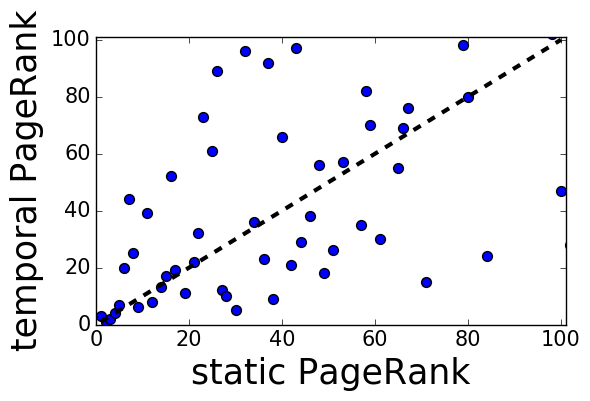

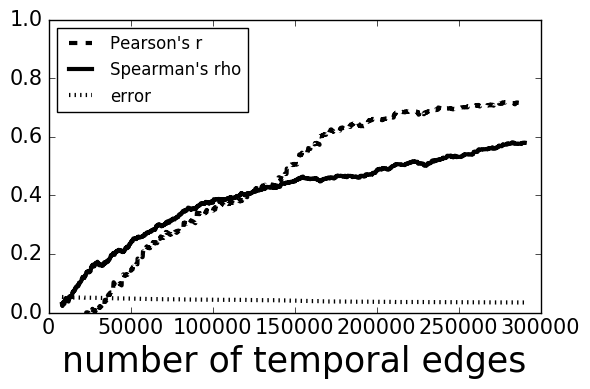

In [25]:
ordered_pr_ref_basic, ordered_pr_out_basic = get_ordered_ranks(pr_basic, RS4_basic)
#ordered_pr_ref_nopers, ordered_pr_out_nopers = get_ordered_ranks(pr_nopers, RS4_nopers)
#ordered_pr_ref_rand, ordered_pr_out_rand = get_ordered_ranks(pr_rand, RS4_rand)
    
plt.rcParams.update({'font.size': 10, 'lines.linewidth': 3})
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

mode = 'facebook'
        
# scatter plot for rankings
plt.figure('scatter_' + mode)
plt.scatter(ordered_pr_ref_basic, ordered_pr_out_basic, s=50, c='b')
plt.plot(range(1, 101), range(1, 101), 'k--')
plt.xlabel('static PageRank', fontsize=25)
plt.ylabel('temporal PageRank', fontsize=25)
plt.ylim((0, 101))
plt.xlim((0, 101))
plt.tight_layout()
#plt.savefig(mode + '_scatter.pdf')
plt.show()
        
        
plt.figure('convergence_basic_' + mode)        
plt.plot(x, pearson_basic, 'k--')
plt.plot(x, spearman_basic, 'k-')
#plt.plot(x, tau_basic, 'k-.')
plt.plot(x, error_basic, 'k:')
plt.xlabel('number of temporal edges', fontsize=25)
plt.ylim((0, 1))
plt.legend(['Pearson\'s r', 'Spearman\'s rho', 'error'], loc=0)
plt.tight_layout()
#plt.savefig(mode+'_convergence_basic.pdf')
plt.show()